# **VQA** - homework 3 - D. Merli,  B. Gallazzi

### Kaggle API Setup

In order to use kaggle-api to download the dataset, and automatically upload submissions it is needed the kaggle.json file obtainable from the user profile on Kaggle site.

This cell asks the user to upload his kaggle.json file and stores it into ~/.kaggle as stated in the complete installation guide: [Installation Guide - github](https://github.com/Kaggle/kaggle-api)


In [ ]:
!pip install --upgrade  --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle

from google.colab import files
files.upload()

!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json
!kaggle competitions download -c anndl-2020-vqa
!cd /content/ && unzip -q anndl-2020-vqa.zip

In [2]:
# main imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import json
import math 
import cv2
import os

In [3]:
# Labels definition for question answering

labels_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    'apple': 6,
    'baseball': 7,
    'bench': 8,
    'bike': 9,
    'bird': 10,
    'black': 11,
    'blanket': 12,
    'blue': 13,
    'bone': 14,
    'book': 15,
    'boy': 16,
    'brown': 17,
    'cat': 18,
    'chair': 19,
    'couch': 20,
    'dog': 21,
    'floor': 22,
    'food': 23,
    'football': 24,
    'girl': 25,
    'grass': 26,
    'gray': 27,
    'green': 28,
    'left': 29,
    'log': 30,
    'man': 31,
    'monkey bars': 32,
    'no': 33,
    'nothing': 34,
    'orange': 35,
    'pie': 36,
    'plant': 37,
    'playing': 38,
    'red': 39,
    'right': 40,
    'rug': 41,
    'sandbox': 42,
    'sitting': 43,
    'sleeping': 44,
    'soccer': 45,
    'squirrel': 46,
    'standing': 47,
    'stool': 48,
    'sunny': 49,
    'table': 50,
    'tree': 51,
    'watermelon': 52,
    'white': 53,
    'wine': 54,
    'woman': 55,
    'yellow': 56,
    'yes': 57
}


# Util to decode integer classes into string labels
class_dict = {v:k for k, v in labels_dict.items()}

In [4]:
imgs_path = "/content/VQA_Dataset/Images"
test_json_path = "/content/VQA_Dataset/test_questions.json"
train_json_path = "/content/VQA_Dataset/train_questions_annotations.json"


def get_dataset(path):
    with open(path) as f:
        data = json.load(f).values()

        return pd.DataFrame.from_dict(data)


def get_testset(path):
    with open(path) as f:
        data = json.load(f)

        return pd.DataFrame.from_dict(data).transpose()


# Load dataset and testset as DataFrames
dataset = get_dataset(train_json_path)
test_set = get_testset(test_json_path)

In [33]:
# define seed and other variables

SEED = 0xDEADBEEF
img_h, img_w = 299, 299
BATCH_SIZE = 128
N_CLASSES = len(labels_dict)

np.random.seed(SEED)

In [37]:
from nltk.stem import PorterStemmer
from functools import lru_cache
import nltk

porter_stemmer = PorterStemmer()

@lru_cache()
def get_image(img_id):
    img = cv2.imread(f'{imgs_path}/{img_id}.png')
    img = cv2.resize(img, (img_w, img_h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/ 255.
    return img


# Removing question marks from questions
def preprocess_question(question):
    question = question.lower()
    question = question.replace('?', '')

    question = ' '.join([porter_stemmer.stem(w) for w in question.split(' ')])

    nltk

    return question

# Tokenize (using tokenizer and max_length from the global scope)
def tokenize_question(question):
    question = tokenizer.texts_to_sequences([question])[0]
    question = pad_sequences([question], maxlen=max_length, padding='post')[0]
    
    return question

In [7]:
# Get all the questions in a list
all_questions = list(dataset['question']) + list(test_set['question'])

tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Fit questions into the tokenizer
for question in tqdm(all_questions, desc='Fitting tokenizer'):
    question = preprocess_question(question)

    tokenizer.fit_on_texts(question.split(' '))         

Fitting tokenizer: 100%|██████████| 65204/65204 [02:06<00:00, 516.41it/s]


In [38]:
words_number = len(tokenizer.word_index) + 1

# Obtain max_length (alias the maximum number of tokens in a sentence, 
# which is the lenght the other questions will be padded to)

sequences = tokenizer.texts_to_sequences([preprocess_question(q) for q in all_questions])
max_length = max(len(sequence) for sequence in sequences)

print('words number:', words_number)
print('max sequence length:', max_length)

words number: 3376
max sequence length: 21


In [9]:
print(dataset)

                                question image_id   answer
0                     Who looks happier?    11779      man
1            Where is the woman sitting?    11779  blanket
2              Where is the man sitting?    11779    bench
3                    Is this man hungry?     5536      yes
4           Who is holding the football?    16949      man
...                                  ...      ...      ...
58827               What animal is that?    23778      dog
58828  Is there a fire in the fireplace?    23778      yes
58829      How many pillows on the sofa?    23778        2
58830         How many people are there?    28836        0
58831             What is on the pillow?    28836     book

[58832 rows x 3 columns]


In [10]:
# Preprocess dataset and testset questions directly inside the DataFrame for better
# performance during training

dataset['question'] = dataset['question'].apply(preprocess_question)
test_set['question'] = test_set['question'].apply(preprocess_question)

In [11]:
print(dataset)

                              question image_id   answer
0                     who look happier    11779      man
1               where is the woman sit    11779  blanket
2                 where is the man sit    11779    bench
3                    is thi man hungri     5536      yes
4              who is hold the footbal    16949      man
...                                ...      ...      ...
58827                what anim is that    23778      dog
58828  is there a fire in the fireplac    23778      yes
58829      how mani pillow on the sofa    23778        2
58830         how mani peopl are there    28836        0
58831            what is on the pillow    28836     book

[58832 rows x 3 columns]


In [12]:
# Tokenize phrases

dataset['question'] = dataset['question'].apply(tokenize_question)
test_set['question'] = test_set['question'].apply(tokenize_question)

In [13]:
# Split the dataset into training and validation
training_set, validation_set = train_test_split(dataset, train_size=0.8, random_state=SEED)


# Print training, valid, and test sets to check everything is going smoothly
print(training_set)
print(validation_set)
print(test_set)

                                                question image_id answer
53104  [3, 10, 61, 32, 8, 1, 132, 0, 0, 0, 0, 0, 0, 0...    20861     no
47458  [3, 1, 348, 7, 1, 844, 351, 0, 0, 0, 0, 0, 0, ...    29796     no
5141   [5, 6, 93, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...    18486      2
1175   [2, 158, 201, 1, 155, 0, 0, 0, 0, 0, 0, 0, 0, ...    14897     no
38140  [29, 2, 1, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      741  floor
...                                                  ...      ...    ...
39730  [5, 6, 120, 207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    23565      1
2296   [2, 10, 11, 13, 7, 1, 117, 99, 0, 0, 0, 0, 0, ...      886    yes
43280  [5, 6, 25, 3, 276, 12, 28, 7, 11, 485, 594, 0,...    29920      2
34205  [4, 2, 7, 1, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     1326    pie
56528  [19, 1, 14, 24, 61, 98, 0, 0, 0, 0, 0, 0, 0, 0...    27317    yes

[47065 rows x 3 columns]
                                                question image_id answer
15002  [79, 30, 55, 217, 

In [39]:
# Custom Dataset generator, based on tf.keras.utils.Sequence
# Every epoch, if shuffle=True, the dataset is scrambled for better randomization

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, is_testset=False, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.is_testset = is_testset
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        # generate a batch of indexes
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        # obtain input data from the generated batch indexes 
        X = self.__generate_X(batch)

        if not self.is_testset:
            # if training set, get also the encoding for the answers
            y = self.__generate_y(batch)

            return X, y
        else:
            return X, []

    def on_epoch_end(self):
        # shuffle dataset on epoch end
        self.index = np.arange(len(self.indices))

        if self.shuffle:
            np.random.shuffle(self.index)

    def __generate_X(self, batch):
        images = []
        questions = []

        for i, ID in enumerate(batch):
            input_question = self.df.loc[ID]['question']
            input_image = get_image(self.df.loc[ID]['image_id'])
            
            images += [input_image]
            questions += [input_question]

        X1 = np.array(images)
        X2 = np.array(questions)

        return [X1, X2]

    def __generate_y(self, batch):
        outputs = []

        for i, ID in enumerate(batch):
            output = labels_dict[self.df.loc[ID]['answer']] 
            outputs += [tf.one_hot(output, len(labels_dict))]

        y = np.array(outputs)

        return y

In [59]:
# Initialize generators

train_generator = DataGenerator(training_set, batch_size=BATCH_SIZE)
valid_generator = DataGenerator(validation_set, batch_size=BATCH_SIZE)

TEST_BATCHSIZE = 118 # test batch size needs to be a divisor of 6372

test_generator = DataGenerator(test_set, batch_size=TEST_BATCHSIZE, is_testset=True, shuffle=False)

print('train batches:', len(train_generator))
print('valid batches:', len(valid_generator))
print('test batches:', len(test_generator))

train batches: 367
valid batches: 91
test batches: 54


In [41]:
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3

def cnn_model():
    cnn = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
    cnn.trainable = False

    return cnn

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential

EMBEDDING_SIZE = 128

# Define CNN for Image Input
CNN_MODEL = cnn_model()

vision_model = Sequential()
vision_model.add(CNN_MODEL)
# Flatten pre-trained features, and add 2 Dense layers (+ Dropout for regularization)
vision_model.add(GlobalAveragePooling2D())
vision_model.add(Dense(1024, activation='relu'))
vision_model.add(Dropout(0.2))
vision_model.add(Dense(1024, activation='relu'))
vision_model.add(Dropout(0.2))

image_input = Input(shape=(img_h, img_w, 3))
encoded_image = vision_model(image_input)

# Qustion Input (with max_length size)
question_input = Input(shape=[max_length], dtype='int32')

# Text embedding
embedded_question = Embedding(
    input_dim=len(tokenizer.word_index) + 1, 
    output_dim=EMBEDDING_SIZE, 
    input_length=max_length)(question_input)

# 2 LSTM Layers (+ Dropout for regularization)
lstm_1 = LSTM(1024, go_backwards=True, return_sequences=True)(embedded_question)
d_1 = Dropout(0.2)(lstm_1)
lstm_2 = LSTM(1024)(d_1)
d_2 = Dropout(0.2)(lstm_2)

encoded_question = Dense(1024, activation='relu')(d_2)

# Combine RNN and CNN with multiplication 
merged = tf.keras.layers.Multiply()([encoded_question, encoded_image])

dense_1 = Dense(1024, activation='relu')(merged)
dd_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(1024, activation='relu')(dd_1)
dd_2 = Dropout(0.2)(dense_2)

output = Dense(N_CLASSES, activation='softmax')(dd_2)

# Get the final model
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

In [43]:
vqa_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 21, 128)      432128      input_12[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 21, 1024)     4722688     embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 21, 1024)     0           lstm_6[0][0]                     
____________________________________________________________________________________________

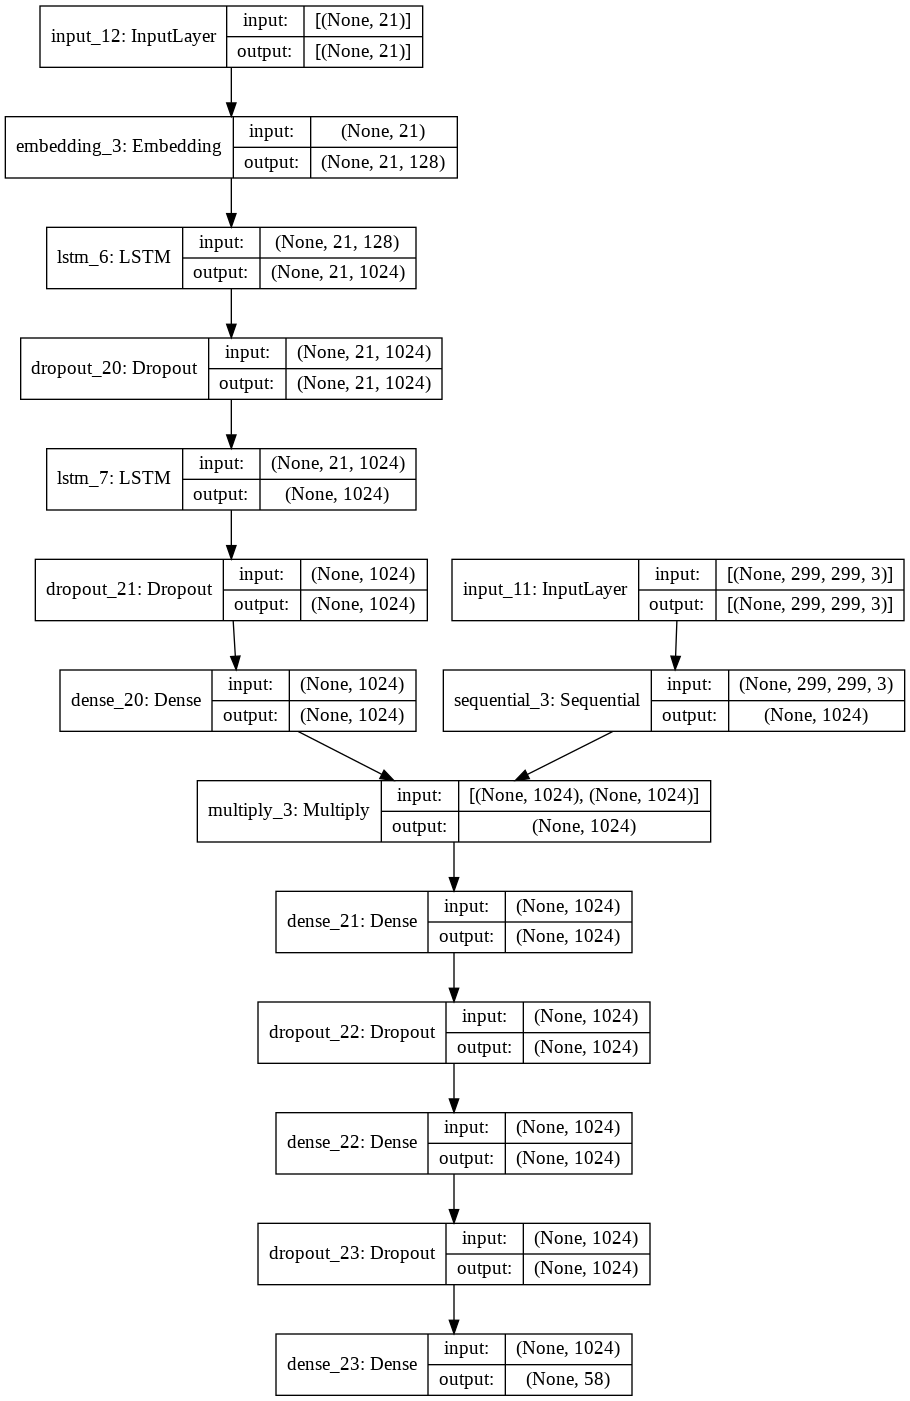

In [44]:
from keras.utils.vis_utils import plot_model
plot_model(vqa_model, show_shapes=True, show_layer_names=True)

In [47]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.5, 
                                   patience=3, 
                                   verbose=1, 
                                   mode='min', 
                                   min_delta=0.0001, 
                                   cooldown=2, 
                                   min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5,
                      restore_best_weights=True)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [48]:
vqa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
vqa_model.fit(train_generator, 
                validation_data=valid_generator, 
                steps_per_epoch=len(train_generator),
                validation_steps=len(valid_generator), 
                callbacks=callbacks_list,
                epochs=10)

Epoch 1/10
367/367 [==============================] - 501s 1s/step - loss: 2.3546 - accuracy: 0.3541 - val_loss: 1.3561 - val_accuracy: 0.4843

Epoch 00001: val_loss improved from inf to 1.35609, saving model to model_weights.best.hdf5
Epoch 2/10
367/367 [==============================] - 493s 1s/step - loss: 1.3093 - accuracy: 0.4996 - val_loss: 1.1577 - val_accuracy: 0.5369

Epoch 00002: val_loss improved from 1.35609 to 1.15766, saving model to model_weights.best.hdf5
Epoch 3/10
367/367 [==============================] - 492s 1s/step - loss: 1.1044 - accuracy: 0.5608 - val_loss: 1.0888 - val_accuracy: 0.5586

Epoch 00003: val_loss improved from 1.15766 to 1.08879, saving model to model_weights.best.hdf5
Epoch 4/10
367/367 [==============================] - 491s 1s/step - loss: 1.0479 - accuracy: 0.5792 - val_loss: 1.1011 - val_accuracy: 0.5680

Epoch 00004: val_loss did not improve from 1.08879
Epoch 5/10
367/367 [==============================] - 488s 1s/step - loss: 1.0003 - accur

In [50]:
# Fine Tune the InceptionV3 used for the extraction of the features from the images
CNN_MODEL.trainable = True

vqa_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 21, 128)      432128      input_12[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 21, 1024)     4722688     embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 21, 1024)     0           lstm_6[0][0]                     
____________________________________________________________________________________________

In [51]:
vqa_model.fit(train_generator, 
                validation_data=valid_generator, 
                steps_per_epoch=len(train_generator),
                validation_steps=len(valid_generator), 
                callbacks=callbacks_list,
                epochs=10) 


Epoch 1/10
367/367 [==============================] - 488s 1s/step - loss: 0.8186 - accuracy: 0.6598 - val_loss: 0.9666 - val_accuracy: 0.6185

Epoch 00001: val_loss did not improve from 0.95797
Epoch 2/10
367/367 [==============================] - 489s 1s/step - loss: 0.7961 - accuracy: 0.6694 - val_loss: 0.9966 - val_accuracy: 0.6174

Epoch 00002: val_loss did not improve from 0.95797
Epoch 3/10
367/367 [==============================] - 487s 1s/step - loss: 0.7821 - accuracy: 0.6770 - val_loss: 1.0118 - val_accuracy: 0.6093

Epoch 00003: val_loss did not improve from 0.95797
Epoch 4/10
367/367 [==============================] - 488s 1s/step - loss: 0.7692 - accuracy: 0.6816 - val_loss: 0.9914 - val_accuracy: 0.6158

Epoch 00004: val_loss did not improve from 0.95797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
367/367 [==============================] - 487s 1s/step - loss: 0.7060 - accuracy: 0.7062 - val_loss: 0.9900 - val_accuracy: 0.6

In [60]:
# Get predictions on the testset
predictions = vqa_model.predict(test_generator, batch_size=TEST_BATCHSIZE)

In [ ]:
# Check that predictions and the testset have the same length
assert len(predictions) == len(test_set['image_id'])

RESULT_IDS = [r[0] for r in test_set.iterrows()]

# Generate results dict 
results_dict = {RESULT_IDS[i]:np.argmax(predictions[i]) for i, img_id in enumerate(test_set['image_id'])}

print(results_dict)

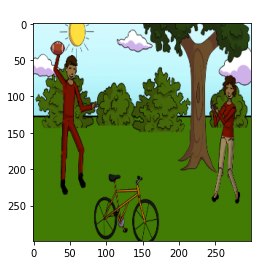

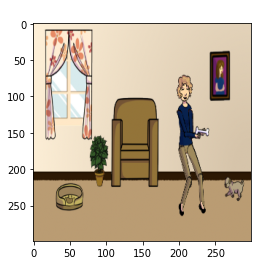

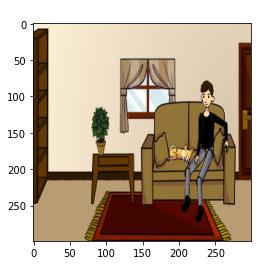

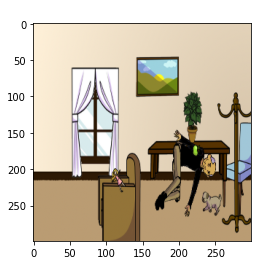

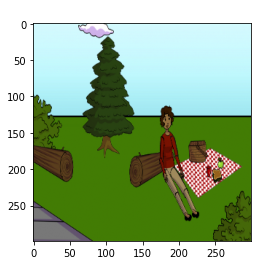

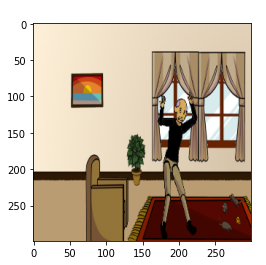

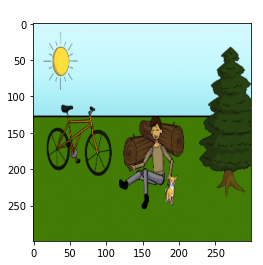

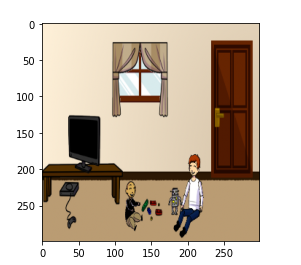

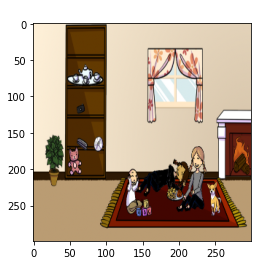

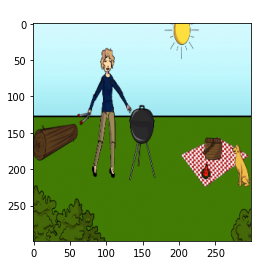

In [58]:
from time import sleep
from PIL import Image

# Print example [question, image] => answer, from the testset
# (questions are displayed with white color, so may not be visible on an editor with light theme)
for i in list(get_testset(test_json_path).iterrows())[:10]:
    ID, data = i

    plt.figure()
    plt.title(f"{data['question']} - {class_dict[results_dict[ID]]}", 
              color='white',
              fontsize=14)
    
    plt.imshow(get_image(data['image_id']))

In [55]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):
    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

    return csv_fname

In [56]:
# Save the results in a file
results_file = create_csv(results_dict)

In [57]:
# Submit results directly to kaggle with the kaggle API
!kaggle competitions submit -c anndl-2020-vqa -f $results_file -m $results_file

100% 58.6k/58.6k [00:02<00:00, 22.8kB/s]
Successfully submitted to Artificial Neural Network and Deep Learning 2020